In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import img_as_float
from skimage.filters import frangi

#ocena skuteczności
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
import numpy as np
from scipy.stats import gmean
import pandas as pd

In [5]:
#Wybór pliku

nazwa_pliku = '01_g'

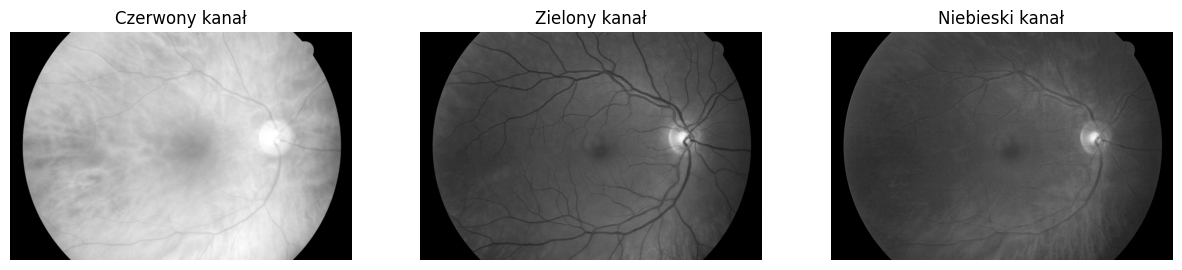

In [6]:
# Wczytaj obraz kolorowy (BGR)
img = cv2.imread('all/images/'+ nazwa_pliku +'.jpg')

# Wyodrębnij zielony, czerwony i niebieski kanał
green_channel = img[:, :, 1]
red_channel = img[:, :, 2]
blue_channel = img[:, :, 0]

image = green_channel

# Wyświetl wszystkie kanały obok siebie
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.imshow(red_channel, cmap='gray')
plt.title('Czerwony kanał')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(green_channel, cmap='gray')
plt.title('Zielony kanał')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(blue_channel, cmap='gray')
plt.title('Niebieski kanał')
plt.axis('off')

plt.show()

In [7]:
print(green_channel[1000][2500:2700])

#print(green_channel.shape)
#rozmiar obrazu: (2336, 3504)

[ 87  87  86  87  87  87  87  87  87  87  88  88  87  89  90  91  93  94
  95  95  97  98  98  99 100 100  99  99  97  98  98  98  97  97  95  93
  95  95  97  96  96  98 100  99  99 100 100 100 102 102 102 102 102  99
 102 103 105 105 105 107 110 109 112 114 116 116 117 119 121 120 120 120
 121 123 125 125 125 125 126 127 125 125 125 124 123 123 122 121 120 120
 119 117 118 119 118 117 115 114 113 113 111 111 110 109 109 110 111 111
 112 111 111 113 112 109 109 111 108 108 107 107 107 106 106 107 107 107
 107 107 108 108 105 102 100  96  94  91  89  88  87  86  84  84  86  87
  90  93  96  98 103 103 105 106 106 106 108 108 107 107 107 106 105 105
 104 104 106 105 105 104 104 105 105 106 107 105 105 105 105 105 103 104
 104 104 104 104 104 104 104 104 104 104 104 104 104 104 104 103 103 101
 100 100]


In [8]:
#wczytywanie maski
mask = cv2.imread('all/mask/'+ nazwa_pliku +'_mask.tif', cv2.IMREAD_GRAYSCALE)

# Zamień wartości 0/255 na 0/1 typu int
mask_norm = (mask > 127).astype(int)

print(mask_norm[1000][100:200])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [9]:
# Ograniczenie wartości pikseli (opcjonalnie)
image = np.clip(image, 10, 245)

# Zastosowanie CLAHE (poprawa kontrastu lokalnego)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
image_clahe = clahe.apply(image)

# Konwersja do float w zakresie 0-1 (wymagane przez frangi)
image_float = img_as_float(image_clahe)

# Zastosowanie filtra Frangi
frangi_result = frangi(image_float, sigmas=np.arange(2, 20, 1), black_ridges=True)

# Normalizacja wyniku filtra Frangi
frangi_norm = frangi_result / frangi_result.max()

# Ustawienie progu (możesz testować różne wartości)
threshold = 0.03
binary_mask = np.where(frangi_norm > threshold, 1, 0)

result = binary_mask & mask_norm


In [10]:
#wczytywanie poprawnego rozwiązania
correct_output = cv2.imread('all/manual1/'+ nazwa_pliku +'.tif', cv2.IMREAD_GRAYSCALE)

# Zamień wartości 0/255 na 0/1 typu int
correct_output_norm = (correct_output > 127).astype(int)

print(correct_output_norm[1000][100:200])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
#Macierz pomyłek
y_true = correct_output_norm.flatten()
y_pred = result.flatten()
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()


# sprawdzenie czy suma parametrów się zgadza TP+TN+FP+FN=N
print(tn+ fp+ fn+ tp == 2336* 3504)


# Trafność (accuracy)
accuracy = accuracy_score(y_true, y_pred)

# Czułość (sensitivity, recall)
sensitivity = recall_score(y_true, y_pred, pos_label=1)  # TP / (TP + FN)

# Swoistość (specificity)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Średnie metryki (dla danych niezrównoważonych)
mean_arithmetic = (sensitivity + specificity) / 2
mean_geometric = gmean([sensitivity, specificity]) if sensitivity > 0 and specificity > 0 else 0


print("Macierz pomyłek:\n", cm)
print("\n")
print(f"Trafność (accuracy): {accuracy:.4f}")
print(f"Czułość (sensitivity): {sensitivity:.4f}")
print(f"Swoistość (specificity): {specificity:.4f}")
print(f"Średnia arytmetyczna (sens & spec): {mean_arithmetic:.4f}")
print(f"Średnia geometryczna (sens & spec): {mean_geometric:.4f}")


True
Macierz pomyłek:
 [[7405128  232584]
 [ 301341  246291]]


Trafność (accuracy): 0.9348
Czułość (sensitivity): 0.4497
Swoistość (specificity): 0.9695
Średnia arytmetyczna (sens & spec): 0.7096
Średnia geometryczna (sens & spec): 0.6603


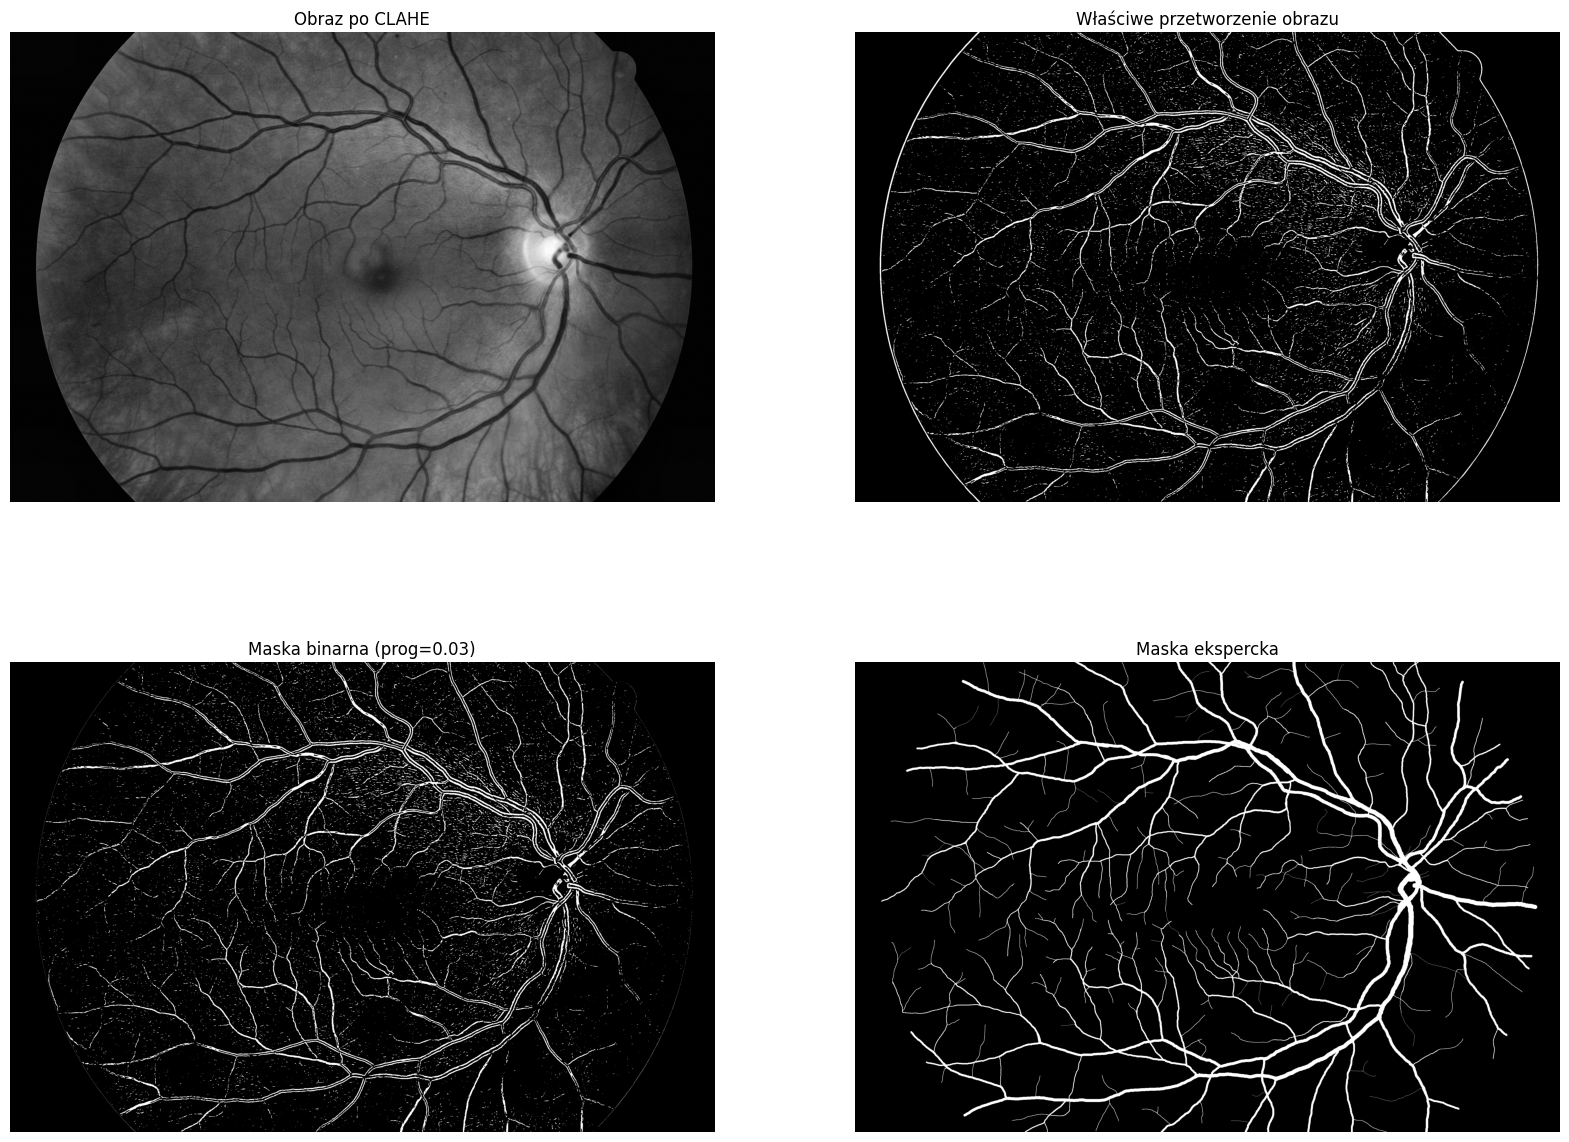

Macierz pomyłek:
[[7405128  232584]
 [ 301341  246291]]


,Metryka,Wartość
0,Trafność (accuracy),0.9348
1,Czułość (sensitivity),0.4497
2,Swoistość (specificity),0.9695
3,Średnia arytmetyczna,0.7096
4,Średnia geometryczna,0.6603


In [12]:
# Wyświetlenie wyników
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.imshow(image_clahe, cmap='gray')
plt.title('Obraz po CLAHE')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(binary_mask, cmap='gray')
plt.title(f'Właściwe przetworzenie obrazu')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(result, cmap='gray')
plt.title(f'Maska binarna (prog={threshold})')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(correct_output, cmap='gray')
plt.title(f'Maska ekspercka')
plt.axis('off')

plt.show()


# Tworzymy ramkę danych (tabelę)
metrics_df = pd.DataFrame({
    'Metryka': [
        'Trafność (accuracy)',
        'Czułość (sensitivity)',
        'Swoistość (specificity)',
        'Średnia arytmetyczna',
        'Średnia geometryczna'
    ],
    'Wartość': [
        accuracy,
        sensitivity,
        specificity,
        mean_arithmetic,
        mean_geometric
    ]
})

# Wyświetlenie macierzy pomyłek
print("Macierz pomyłek:")
print(cm)

# Wyświetlenie tabeli
metrics_df.style.format({"Wartość": "{:.4f}"})